In [ ]:
import pandas as pd
import joblib
import warnings
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import BaseEstimator, ClassifierMixin
from raiwidgets import ResponsibleAIDashboard
from responsibleai import RAIInsights
from responsibleai.feature_metadata import FeatureMetadata

warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("RESPONSIBLE AI DASHBOARD - HEART DISEASE PREDICTION")
print("="*70)

# ==========================================================
# CONFIGURATION
# ==========================================================

# Categorical feature mappings for interpretability
CATEGORICAL_MAPPINGS = {
    # Binary/Ordinal features (1-based)
    'Sex': {1: 'Female', 2: 'Male'},
    'Cholesterol_Level': {1: 'Normal', 2: 'Borderline High', 3: 'High'},
    'Glucose_Level': {1: 'Normal', 2: 'Prediabetes', 3: 'Diabetes'},
    'Smoking_Status': {1: 'Non-Smoker', 2: 'Smoker'},
    'Alcohol_Intake': {1: 'No/Rarely', 2: 'Yes/Regularly'},
    'Physical_Activity': {1: 'Active', 2: 'Inactive/Low'},
    
    # Binned/Grouped features (0-based indexing)
    'Age_Group': {0: '<40', 1: '40-44', 2: '45-49', 3: '50-54', 
                  4: '55-59', 5: '60-64', 6: '65-69', 7: '70+'},
    'BMI_Group': {0: 'Normal/Underweight', 1: 'Overweight', 
                  2: 'Obese I', 3: 'Obese II/III'},
    'BP_Group': {0: 'Normal', 1: 'Elevated', 
                 2: 'Stage 1 Hypertension', 3: 'Stage 2+ Hypertension'},
    'PP_Group': {0: 'Low (<40)', 1: 'Normal (40-60)', 2: 'High (>60)'},
    'MAP_Group': {0: 'Low (<93)', 1: 'Normal (93-100)', 
                  2: 'Elevated (100-110)', 3: 'High (>110)'}
}

# Paths
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / 'artifacts' / 'split data sets'
MODEL_DIR = PROJECT_ROOT / 'artifacts' / 'model'

# Settings
TARGET_COLUMN = 'Heart_Disease'
SAMPLE_SIZE = 5000
RANDOM_STATE = 42

# ==========================================================
# LOAD MODEL
# ==========================================================

print("\n[1/6] Loading model...")
model_path = MODEL_DIR / 'best_model_base.pkl'

if not model_path.exists():
    raise FileNotFoundError(f"Model not found: {model_path}")

artifacts = joblib.load(model_path)

# Extract model and metadata
base_model = artifacts['model']
features = artifacts.get('features', None)
model_type = artifacts.get('model_type', 'Unknown')
model_name = artifacts.get('model_name', 'Best Model (Base)')

print(f"✓ Model Type: {model_type}")
print(f"✓ Model Name: {model_name}")
print(f"✓ Model Class: {type(base_model).__name__}")

# ==========================================================
# LOAD DATA
# ==========================================================

print("\n[2/6] Loading data...")
X_train_full = pd.read_parquet(DATA_DIR / 'X_train.parquet')
X_test_full = pd.read_parquet(DATA_DIR / 'X_test.parquet')
y_train = pd.read_parquet(DATA_DIR / 'y_train.parquet').iloc[:, 0]
y_test = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0]

# Ensure feature order matches
if features:
    X_train_full = X_train_full[features]
    X_test_full = X_test_full[features]
    print(f"✓ Features aligned: {len(features)}")

print(f"✓ Train: {X_train_full.shape}, Test: {X_test_full.shape}")

# ==========================================================
# DECODE CATEGORICAL FEATURES
# ==========================================================

print("\n[3/6] Decoding categorical features...")

def decode_categorical_features(df, mappings):
    """Convert numeric codes to text labels for categorical features"""
    df_decoded = df.copy()
    decoded_count = 0
    
    for col, mapping in mappings.items():
        if col in df_decoded.columns:
            # Convert to categorical with text labels
            df_decoded[col] = df_decoded[col].apply(
                lambda x: mapping.get(int(round(x)), str(int(round(x))))
            ).astype('category')
            decoded_count += 1
    
    return df_decoded, decoded_count

X_train_decoded, train_count = decode_categorical_features(X_train_full, CATEGORICAL_MAPPINGS)
X_test_decoded, test_count = decode_categorical_features(X_test_full, CATEGORICAL_MAPPINGS)

print(f"✓ Decoded {train_count} categorical features in training data")
print(f"✓ Decoded {test_count} categorical features in test data")

# Show example of decoded features
if train_count > 0:
    example_features = list(CATEGORICAL_MAPPINGS.keys())[:3]
    print(f"\n  Example decoded features:")
    for feat in example_features:
        if feat in X_train_decoded.columns:
            unique_vals = X_train_decoded[feat].unique()[:5]
            print(f"    {feat}: {', '.join(map(str, unique_vals))}")

# ==========================================================
# CREATE MODEL WRAPPER
# ==========================================================

print("\n[4/6] Creating model wrapper...")

class RAICompatibleWrapper(BaseEstimator, ClassifierMixin):
    """
    Wrapper that accepts decoded categorical data but converts back to numeric
    for prediction (since model was trained on numeric features)
    """
    def __init__(self, model, categorical_mappings):
        self.model = model
        self.categorical_mappings = categorical_mappings
        self.classes_ = np.array([0, 1])
        
        # Create reverse mappings (text -> numeric)
        self.reverse_mappings = {}
        for feat, mapping in categorical_mappings.items():
            self.reverse_mappings[feat] = {v: k for k, v in mapping.items()}
    
    def _encode_features(self, X):
        """Convert text labels back to numeric codes"""
        if isinstance(X, pd.DataFrame):
            X_encoded = X.copy()
            for col in X_encoded.columns:
                if col in self.reverse_mappings:
                    # Convert text back to numeric
                    X_encoded[col] = X_encoded[col].map(
                        self.reverse_mappings[col]
                    ).fillna(X_encoded[col])
            return X_encoded.values
        return X
    
    def fit(self, X, y):
        # Already fitted
        return self
    
    def predict(self, X):
        X_numeric = self._encode_features(X)
        return self.model.predict(X_numeric)
    
    def predict_proba(self, X):
        X_numeric = self._encode_features(X)
        return self.model.predict_proba(X_numeric)

rai_model = RAICompatibleWrapper(base_model, CATEGORICAL_MAPPINGS)
print(f"✓ Wrapped model with categorical decoding support")

# ==========================================================
# IDENTIFY CATEGORICAL FEATURES
# ==========================================================

print("\n[5/6] Identifying categorical features...")

# All features in CATEGORICAL_MAPPINGS are categorical
categorical_features = [col for col in CATEGORICAL_MAPPINGS.keys() 
                       if col in X_train_decoded.columns]

print(f"✓ Total features: {len(X_train_decoded.columns)}")
print(f"✓ Categorical features: {len(categorical_features)}")
if categorical_features:
    print(f"   {', '.join(categorical_features)}")

# ==========================================================
# SAMPLE DATA
# ==========================================================

print("\n[6/6] Preparing data samples...")

if len(X_train_decoded) > SAMPLE_SIZE:
    _, X_train_sample, _, y_train_sample = train_test_split(
        X_train_decoded, y_train, 
        test_size=SAMPLE_SIZE, 
        stratify=y_train, 
        random_state=RANDOM_STATE
    )
else:
    X_train_sample, y_train_sample = X_train_decoded, y_train

if len(X_test_decoded) > SAMPLE_SIZE:
    _, X_test_sample, _, y_test_sample = train_test_split(
        X_test_decoded, y_test, 
        test_size=SAMPLE_SIZE, 
        stratify=y_test, 
        random_state=RANDOM_STATE
    )
else:
    X_test_sample, y_test_sample = X_test_decoded, y_test

# Combine features and target
train_data_rai = X_train_sample.copy()
train_data_rai[TARGET_COLUMN] = y_train_sample.values.astype(int)

test_data_rai = X_test_sample.copy()
test_data_rai[TARGET_COLUMN] = y_test_sample.values.astype(int)

print(f"✓ Train sample: {train_data_rai.shape}")
print(f"✓ Test sample: {test_data_rai.shape}")

# Verify categorical features are properly decoded
print(f"\n  Verification - Sample categorical values:")
for feat in categorical_features[:3]:
    if feat in train_data_rai.columns:
        sample_vals = train_data_rai[feat].head(3).tolist()
        print(f"    {feat}: {sample_vals}")

# ==========================================================
# INITIALIZE RAI DASHBOARD
# ==========================================================

print("\n" + "="*70)
print("INITIALIZING RESPONSIBLE AI DASHBOARD")
print("="*70)

# Create feature metadata with categorical features
feature_metadata = FeatureMetadata(
    categorical_features=categorical_features,
    dropped_features=[]
)
print(f"✓ Feature metadata created")
print(f"  - Categorical: {len(categorical_features)}")
print(f"  - Continuous: {len(X_train_decoded.columns) - len(categorical_features)}")

# Initialize RAI Insights
print("\n⚙️  Creating RAI Insights object...")
rai_insights = RAIInsights(
    model=rai_model,
    train=train_data_rai,
    test=test_data_rai,
    target_column=TARGET_COLUMN,
    task_type='classification',
    feature_metadata=feature_metadata
)
print("✓ RAI Insights initialized")

# Add components
print("\n📊 Adding analysis components...")

print("   1. Explainer (SHAP-based interpretability)...")
rai_insights.explainer.add()
print("      ✓ Added")

print("   2. Error Analysis (cohort-based error detection)...")
rai_insights.error_analysis.add(max_depth=4, num_leaves=10)
print("      ✓ Added")

print("   3. Counterfactual Analysis (what-if scenarios)...")
try:
    rai_insights.counterfactual.add(total_CFs=10, desired_class='opposite')
    print("      ✓ Added")
except Exception as e:
    print(f"      ⚠️  Skipped: {str(e)[:50]}")

# Compute insights
print("\n⏳ Computing insights...")
print("   This may take 3-5 minutes depending on sample size...")
print("   Please wait...")

try:
    rai_insights.compute()
    print("\n✅ Computation complete!")
except Exception as e:
    print(f"\n❌ Error during computation: {str(e)}")
    raise

# ==========================================================
# LAUNCH DASHBOARD
# ==========================================================
ResponsibleAIDashboard(rai_insights)

p:\projects\heart_disease_prediction\heart_env\lib\site-packages\llvmlite\binding\ffi.py:178: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



RESPONSIBLE AI DASHBOARD - HEART DISEASE PREDICTION

[1/5] Loading model...
✓ Model Type: LightGBM
✓ Model Name: LightGBM_base
✓ Model Class: LGBMClassifier

[2/5] Loading data...
✓ Features aligned: 14
✓ Train: (48979, 14), Test: (20992, 14)

[3/5] Creating RAI-compatible wrapper...
✓ Wrapped model: LGBMClassifier

[4/5] Identifying feature types...
✓ Total features: 14
✓ Categorical: 11
   Sex, Cholesterol_Level, Glucose_Level, Smoking_Status, Alcohol_Intake ... (+6 more)

[5/5] Preparing data samples...
✓ Train sample: (5000, 15)
✓ Test sample: (5000, 15)

INITIALIZING RESPONSIBLE AI DASHBOARD
✓ Feature metadata created with 11 categorical features

⚙️  Creating RAI Insights object...
✓ RAI Insights initialized

📊 Adding analysis components...
   1. Explainer (SHAP-based interpretability)...
      ✓ Added
   2. Error Analysis (cohort-based error detection)...
      ✓ Added

⏳ Computing insights...
   This may take 3-5 minutes depending on sample size...
   Please wait...
Causal Eff

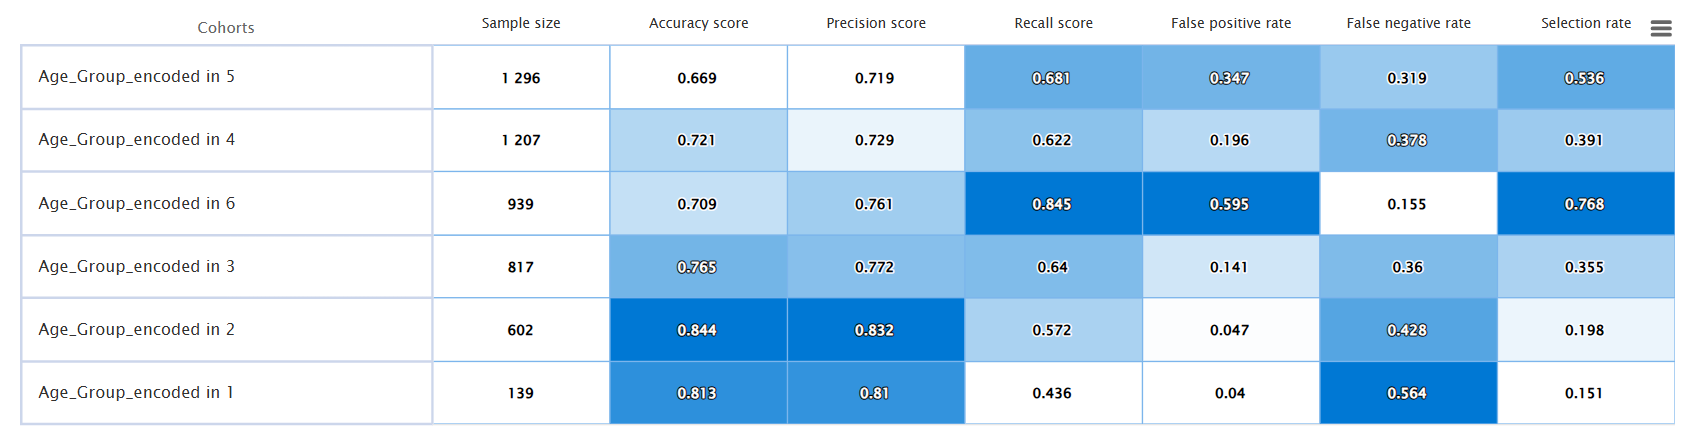

![BMI group.png](<attachment:BMI group.png>)
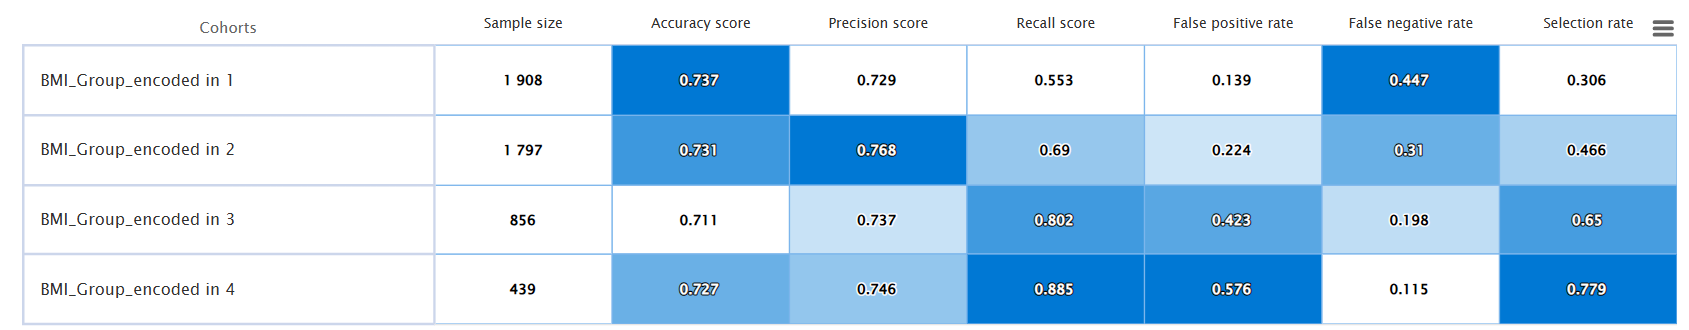

![BP group.png](<attachment:BP group.png>)
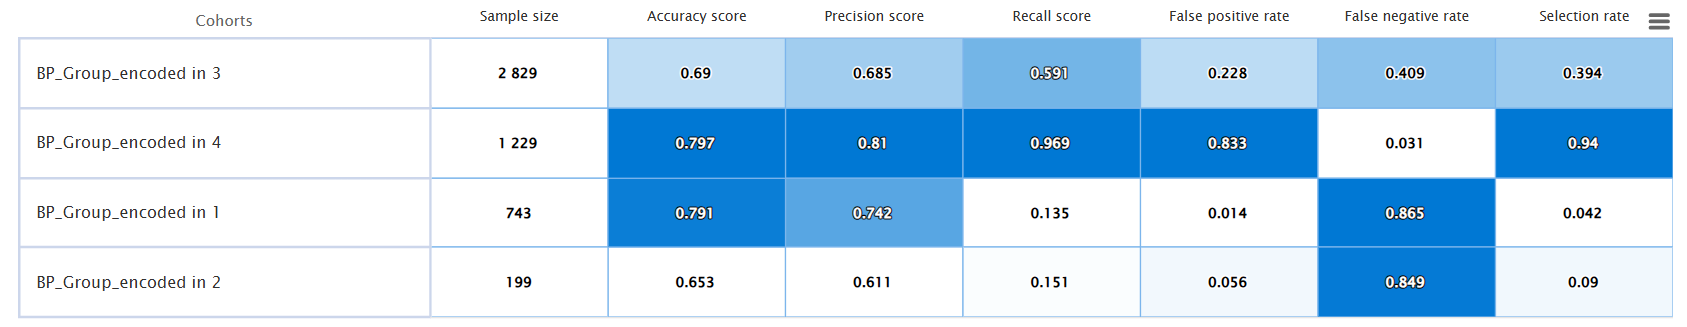

![CHOLESTEROL group.png](<attachment:CHOLESTEROL group.png>)
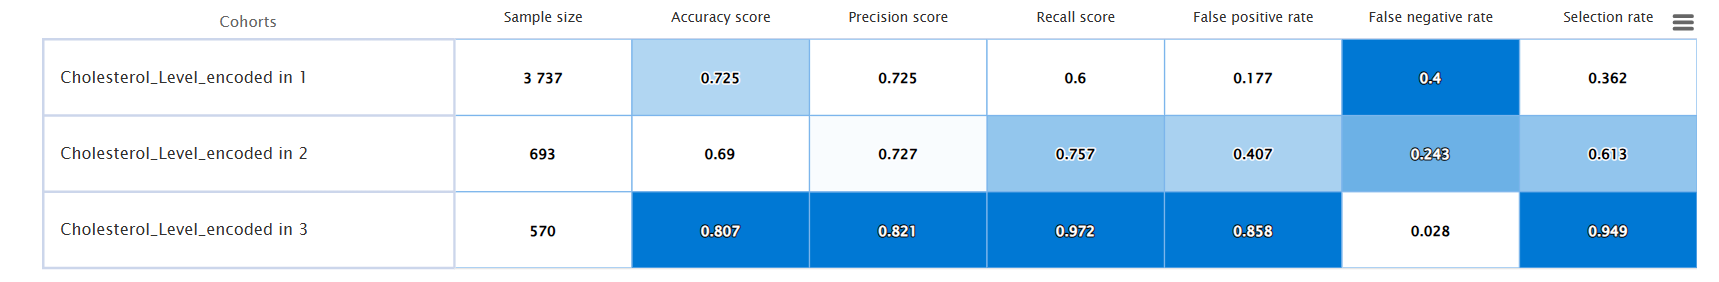

#### To feature-level subclass accuracy, I have employed the custom PyTorch Multi-Task Learning (MTL) model with a shared backbone and task-specific head, training each feature individually to predict the disease label while tracking accuracy and AUC for each feature

In [12]:
import pandas as pd
from pathlib import Path

# load data from data , comprehensive data folder
new_df = pd.read_parquet(r'P:\projects\heart_disease_prediction\data\different data types\comprehensive_data.parquet')
new_df.columns

Index(['Sex', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol_Level',
       'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake',
       'Physical_Activity', 'target', 'Age_Years', 'Age_Group', 'BP_Group',
       'Pulse_Pressure', 'PP_Group', 'MAP', 'MAP_Group', 'BMI', 'BMI_Group',
       'Age_BMI', 'Age_SystolicBP', 'Cholesterol_Risk_Score',
       'BMI_MetabolicVascularLoad', 'Age_HemodynamicLoad_Chol'],
      dtype='object')

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
from sklearn.preprocessing import RobustScaler, StandardScaler

print("Creating YoungLowBP_Paradox with MULTIPLE TRANSFORMATIONS (no clipping)...\n")

# ============================================================================
# PREPARE DATA
# ============================================================================
# Ensure numeric
new_df['Age_Years'] = pd.to_numeric(new_df['Age_Years'], errors='coerce')
new_df['Systolic_BP'] = pd.to_numeric(new_df['Systolic_BP'], errors='coerce')
new_df['Diastolic_BP'] = pd.to_numeric(new_df['Diastolic_BP'], errors='coerce')

# Fill NaN
new_df['Age_Years'].fillna(new_df['Age_Years'].median(), inplace=True)
new_df['Systolic_BP'].fillna(new_df['Systolic_BP'].median(), inplace=True)
new_df['Diastolic_BP'].fillna(new_df['Diastolic_BP'].median(), inplace=True)

print("✓ Data prepared: Age, Systolic BP, Diastolic BP\n")

# ============================================================================
# CREATE BASE RAW SCORE (NO CLIPPING)
# ============================================================================

# Base score: allows NEGATIVE values (meaningful information!)
# Negative = older/high BP (opposite of paradox)
# Positive = younger/low BP (paradoxical)
base_score = (50 - new_df['Age_Years']) * (130 - new_df['Systolic_BP']) * (80 - new_df['Diastolic_BP']) / 1000

print(f"Base raw score statistics:")
print(f"  Range: [{base_score.min():.2f}, {base_score.max():.2f}]")
print(f"  Mean±Std: {base_score.mean():.2f} ± {base_score.std():.2f}")
print(f"  Negative values: {(base_score < 0).sum():,} ({(base_score < 0).mean():.1%})")
print(f"  Positive values: {(base_score > 0).sum():,} ({(base_score > 0).mean():.1%})")

# ============================================================================
# CREATE MULTIPLE TRANSFORMED VARIANTS
# ============================================================================

print("\n" + "="*70)
print("Creating transformed variants...")
print("="*70)

# Variant 1: RAW (no transformation - preserves negatives)
new_df['YoungLowBP_V1_Raw'] = base_score
print("\n✓ V1: Raw multiplicative (preserves sign)")

# Variant 2: SQUARED (amplifies extremes, always positive)
new_df['YoungLowBP_V2_Squared'] = np.sign(base_score) * (base_score ** 2)
print("✓ V2: Signed square (amplifies extremes, preserves direction)")

# Variant 3: CUBE ROOT (compresses extremes, preserves sign)
new_df['YoungLowBP_V3_CubeRoot'] = np.sign(base_score) * (np.abs(base_score) ** (1/3))
print("✓ V3: Cube root (compresses extremes, preserves sign)")

# Variant 4: LOG TRANSFORMATION (handles skewness)
# Add constant to make all positive, then log, then center
base_shifted = base_score - base_score.min() + 1  # Shift to positive
new_df['YoungLowBP_V4_Log'] = np.log1p(base_shifted)  # log(1 + x)
print("✓ V4: Log transformation (handles skewness)")

# Variant 5: TANH (bounds to -1 to 1, sigmoid-like)
# Scale first to reasonable range
scaled_base = base_score / (np.abs(base_score).std() + 1e-8)
new_df['YoungLowBP_V5_Tanh'] = np.tanh(scaled_base)
print("✓ V5: Tanh (bounded sigmoid, -1 to 1)")

# Variant 6: ROBUST SCALING (resistant to outliers)
scaler_robust = RobustScaler()
new_df['YoungLowBP_V6_Robust'] = scaler_robust.fit_transform(base_score.values.reshape(-1, 1)).flatten()
print("✓ V6: Robust scaling (median/IQR based)")

# Variant 7: STANDARD SCALING (z-score)
scaler_standard = StandardScaler()
new_df['YoungLowBP_V7_Standard'] = scaler_standard.fit_transform(base_score.values.reshape(-1, 1)).flatten()
print("✓ V7: Standard scaling (z-score)")

# Variant 8: SQUARE ROOT of ABSOLUTE + SIGN (moderate compression)
new_df['YoungLowBP_V8_Sqrt'] = np.sign(base_score) * np.sqrt(np.abs(base_score))
print("✓ V8: Signed square root (moderate compression)")

# Variant 9: RANK TRANSFORMATION (ordinal, non-parametric)
from scipy.stats import rankdata
new_df['YoungLowBP_V9_Rank'] = rankdata(base_score, method='average')
print("✓ V9: Rank transformation (ordinal)")

# Variant 10: YEO-JOHNSON POWER TRANSFORM (optimal normalization)
from sklearn.preprocessing import PowerTransformer
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
new_df['YoungLowBP_V10_YeoJohnson'] = power_transformer.fit_transform(base_score.values.reshape(-1, 1)).flatten()
print("✓ V10: Yeo-Johnson transform (optimal power)")

print(f"\n✓ Created 10 transformed variants")

# ============================================================================
# VALIDATE ALL VARIANTS
# ============================================================================

# Prepare target
if new_df['target'].dtype == 'object':
    y = new_df['target'].map({'No Disease': 0, 'Disease': 1})
else:
    y = new_df['target']

target = y.values

print("\n" + "="*70)
print("VALIDATION: Testing all transformations")
print("="*70)

variant_names = {
    'YoungLowBP_V1_Raw': 'Raw (No Transform)',
    'YoungLowBP_V2_Squared': 'Signed Square',
    'YoungLowBP_V3_CubeRoot': 'Cube Root',
    'YoungLowBP_V4_Log': 'Log Transform',
    'YoungLowBP_V5_Tanh': 'Tanh (Sigmoid)',
    'YoungLowBP_V6_Robust': 'Robust Scaling',
    'YoungLowBP_V7_Standard': 'Standard Scaling',
    'YoungLowBP_V8_Sqrt': 'Signed Sqrt',
    'YoungLowBP_V9_Rank': 'Rank Transform',
    'YoungLowBP_V10_YeoJohnson': 'Yeo-Johnson'
}

results = {}

for feat_name in variant_names.keys():
    feat = new_df[feat_name].values
    valid = ~(np.isnan(feat) | np.isinf(feat) | np.isnan(target))
    
    # Skip if no variance
    if len(np.unique(feat[valid])) < 2:
        print(f"\n⚠️ {feat_name}: No variance, skipping")
        continue
    
    # AUC
    try:
        auc = roc_auc_score(target[valid], feat[valid])
        auc = max(auc, 1 - auc)
    except:
        auc = 0.5
    
    # Spearman correlation (rank-based, robust)
    try:
        spear_r, spear_p = spearmanr(feat[valid], target[valid])
    except:
        spear_r, spear_p = 0, 1.0
    
    # Pearson correlation (linear)
    try:
        pearson_r = np.corrcoef(feat[valid], target[valid])[0, 1]
    except:
        pearson_r = 0
    
    # Distribution stats
    results[feat_name] = {
        'auc': auc,
        'spearman_r': spear_r,
        'spearman_p': spear_p,
        'pearson_r': pearson_r,
        'abs_spearman': abs(spear_r),  # For ranking
        'mean': feat[valid].mean(),
        'std': feat[valid].std(),
        'min': feat[valid].min(),
        'max': feat[valid].max(),
        'skewness': pd.Series(feat[valid]).skew(),
        'kurtosis': pd.Series(feat[valid]).kurtosis()
    }

# Sort by AUC (primary metric)
sorted_by_auc = sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True)

print("\n" + "="*70)
print("RESULTS: Ranked by AUC")
print("="*70)

print(f"\n{'Rank':<6} {'Variant':<30} {'AUC':<8} {'Spearman':<10} {'Skew':<8} {'Transform':<20}")
print("-" * 95)

for i, (variant, metrics) in enumerate(sorted_by_auc, 1):
    marker = "🏆" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
    print(f"{marker} {i:<4} {variant:<30} {metrics['auc']:.4f}   {metrics['spearman_r']:+.4f}    {metrics['skewness']:+6.2f}  {variant_names[variant]:<20}")

# ============================================================================
# DETAILED TOP 3 COMPARISON
# ============================================================================

print("\n" + "="*70)
print("TOP 3 VARIANTS - DETAILED COMPARISON")
print("="*70)

for i, (variant, metrics) in enumerate(sorted_by_auc[:3], 1):
    feat = new_df[variant].values
    marker = "🏆" if i == 1 else "🥈" if i == 2 else "🥉"
    
    print(f"\n{marker} RANK {i}: {variant} ({variant_names[variant]})")
    print(f"  AUC:            {metrics['auc']:.4f}")
    print(f"  Spearman r:     {metrics['spearman_r']:+.4f} (p={metrics['spearman_p']:.2e})")
    print(f"  Pearson r:      {metrics['pearson_r']:+.4f}")
    print(f"  Range:          [{metrics['min']:.3f}, {metrics['max']:.3f}]")
    print(f"  Mean ± Std:     {metrics['mean']:.3f} ± {metrics['std']:.3f}")
    print(f"  Skewness:       {metrics['skewness']:+.3f} {'(well-balanced)' if abs(metrics['skewness']) < 0.5 else '(skewed)'}")
    print(f"  Kurtosis:       {metrics['kurtosis']:+.3f}")

# ============================================================================
# SELECT BEST VARIANT
# ============================================================================

print("\n" + "="*70)
print("BEST VARIANT SELECTION")
print("="*70)

best_variant = sorted_by_auc[0][0]
best_metrics = sorted_by_auc[0][1]

print(f"\n🏆 WINNER: {best_variant}")
print(f"   Transform: {variant_names[best_variant]}")
print(f"   AUC: {best_metrics['auc']:.4f}")
print(f"   Spearman r: {best_metrics['spearman_r']:+.4f}")

# Show improvement over raw
if best_variant != 'YoungLowBP_V1_Raw':
    raw_auc = results['YoungLowBP_V1_Raw']['auc']
    improvement = best_metrics['auc'] - raw_auc
    improvement_pct = (improvement / raw_auc) * 100
    print(f"\n   Improvement over raw: +{improvement:.4f} ({improvement_pct:+.2f}%)")

# Rename best variant to final name
new_df['YoungLowBP_Paradox'] = new_df[best_variant].copy()

# Drop all temporary variants
temp_variants = list(variant_names.keys())
new_df.drop(temp_variants, axis=1, inplace=True)

print(f"\n✓ Selected variant renamed to: 'YoungLowBP_Paradox'")
print(f"✓ All temporary variants removed")

# ============================================================================
# DISTRIBUTION ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("FINAL FEATURE DISTRIBUTION")
print("="*70)

final_feature = new_df['YoungLowBP_Paradox'].values

print("\nPercentile Distribution:")
percentiles = [0, 1, 5, 10, 25, 50, 75, 90, 95, 99, 100]
for p in percentiles:
    val = np.percentile(final_feature, p)
    print(f"  P{p:>3d}: {val:8.3f}")

# Correlation with target by deciles
print("\nDisease Rate by Feature Deciles:")
try:
    deciles = pd.qcut(final_feature, q=10, labels=[f'D{i}' for i in range(1, 11)], duplicates='drop')
    for d in sorted(deciles.unique()):
        mask = deciles == d
        if mask.sum() > 0:
            disease_rate = target[mask].mean()
            n = mask.sum()
            feat_range = f"[{final_feature[mask].min():.2f}, {final_feature[mask].max():.2f}]"
            print(f"  {d}: {disease_rate:.2%} (n={n:>5,})  Range: {feat_range}")
except:
    print("  (Could not create deciles - may have duplicate edges)")

# ============================================================================
# CLINICAL INTERPRETATION
# ============================================================================

print("\n" + "="*70)
print("CLINICAL INTERPRETATION")
print("="*70)

# Identify high-risk vs low-risk based on feature percentiles
high_threshold = np.percentile(final_feature, 75)
low_threshold = np.percentile(final_feature, 25)

high_risk_mask = final_feature >= high_threshold
low_risk_mask = final_feature <= low_threshold

if high_risk_mask.sum() > 0 and low_risk_mask.sum() > 0:
    disease_high = target[high_risk_mask].mean()
    disease_low = target[low_risk_mask].mean()
    relative_risk = disease_high / (disease_low + 1e-10)
    
    print(f"\nRisk Stratification (by feature quartiles):")
    print(f"  HIGH RISK (Q4, feature ≥ {high_threshold:.3f}):")
    print(f"    Population: {high_risk_mask.sum():,} ({high_risk_mask.mean():.1%})")
    print(f"    Disease rate: {disease_high:.2%}")
    
    print(f"\n  LOW RISK (Q1, feature ≤ {low_threshold:.3f}):")
    print(f"    Population: {low_risk_mask.sum():,} ({low_risk_mask.mean():.1%})")
    print(f"    Disease rate: {disease_low:.2%}")
    
    print(f"\n  Relative Risk (Q4/Q1): {relative_risk:.2f}x")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*70)
print("FINAL FEATURE SUMMARY")
print("="*70)

print(f"\n✓ Feature name:        'YoungLowBP_Paradox'")
print(f"✓ Best transformation: {variant_names[best_variant]}")
print(f"✓ Base formula:        (50 - Age) × (130 - Systolic) × (80 - Diastolic) / 1000")

print(f"\nStatistics:")
print(f"  Range:               [{new_df['YoungLowBP_Paradox'].min():.3f}, {new_df['YoungLowBP_Paradox'].max():.3f}]")
print(f"  Mean ± Std:          {new_df['YoungLowBP_Paradox'].mean():.3f} ± {new_df['YoungLowBP_Paradox'].std():.3f}")
print(f"  Skewness:            {pd.Series(new_df['YoungLowBP_Paradox']).skew():.3f}")

print(f"\nPerformance:")
print(f"  AUC:                 {best_metrics['auc']:.4f}")
print(f"  Spearman r:          {best_metrics['spearman_r']:+.4f}")
print(f"  p-value:             {best_metrics['spearman_p']:.2e}")

print(f"\nAdvantages of '{variant_names[best_variant]}':")
if 'Yeo-Johnson' in variant_names[best_variant]:
    print(f"  ✓ Optimal power transform for normality")
    print(f"  ✓ Handles positive and negative values")
    print(f"  ✓ Reduces skewness automatically")
elif 'Robust' in variant_names[best_variant]:
    print(f"  ✓ Resistant to outliers (uses median/IQR)")
    print(f"  ✓ Stable across different data distributions")
elif 'Rank' in variant_names[best_variant]:
    print(f"  ✓ Fully non-parametric (no distribution assumptions)")
    print(f"  ✓ Maximum robustness to outliers")
elif 'Standard' in variant_names[best_variant]:
    print(f"  ✓ Standard z-score normalization")
    print(f"  ✓ Mean=0, Std=1 (comparable across features)")
elif 'Tanh' in variant_names[best_variant]:
    print(f"  ✓ Bounded to [-1, 1] range")
    print(f"  ✓ Sigmoid-like smooth transformation")
elif 'Square' in variant_names[best_variant]:
    print(f"  ✓ Amplifies extreme values")
    print(f"  ✓ Preserves direction (sign)")
elif 'Cube' in variant_names[best_variant]:
    print(f"  ✓ Compresses extreme values")
    print(f"  ✓ Preserves sign for interpretability")
elif 'Log' in variant_names[best_variant]:
    print(f"  ✓ Handles skewed distributions")
    print(f"  ✓ Compresses large values")
elif 'Sqrt' in variant_names[best_variant]:
    print(f"  ✓ Moderate compression of extremes")
    print(f"  ✓ Preserves sign")
else:
    print(f"  ✓ Preserves raw signal without transformation")
    print(f"  ✓ Maximum interpretability")

print(f"\n✓ COMPLETE! Total columns: {len(new_df.columns)}")
print(f"✓ Ready for modeling with: new_df['YoungLowBP_Paradox']")
print("\n" + "="*70)

Creating YoungLowBP_Paradox with MULTIPLE TRANSFORMATIONS (no clipping)...

✓ Data prepared: Age, Systolic BP, Diastolic BP

Base raw score statistics:
  Range: [-65.30, 44.40]
  Mean±Std: -0.38 ± 2.21
  Negative values: 19,783 (28.3%)
  Positive values: 10,943 (15.6%)

Creating transformed variants...

✓ V1: Raw multiplicative (preserves sign)
✓ V2: Signed square (amplifies extremes, preserves direction)
✓ V3: Cube root (compresses extremes, preserves sign)
✓ V4: Log transformation (handles skewness)
✓ V5: Tanh (bounded sigmoid, -1 to 1)
✓ V6: Robust scaling (median/IQR based)
✓ V7: Standard scaling (z-score)
✓ V8: Signed square root (moderate compression)
✓ V9: Rank transformation (ordinal)
✓ V10: Yeo-Johnson transform (optimal power)

✓ Created 10 transformed variants

VALIDATION: Testing all transformations

RESULTS: Ranked by AUC

Rank   Variant                        AUC      Spearman   Skew     Transform           
----------------------------------------------------------------

In [4]:
new_df.columns

Index(['Sex', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol_Level',
       'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake',
       'Physical_Activity', 'target', 'Age_Years', 'Age_Group', 'BP_Group',
       'Pulse_Pressure', 'PP_Group', 'MAP', 'MAP_Group', 'BMI', 'BMI_Group',
       'Age_BMI', 'Age_SystolicBP', 'Cholesterol_Risk_Score',
       'BMI_MetabolicVascularLoad', 'Age_HemodynamicLoad_Chol',
       'YoungLowBP_Flag', 'YoungLowBP_Paradox', 'YoungLowBP_Score'],
      dtype='object')

In [5]:
cols_to_drop = ['Systolic_BP', 'Diastolic_BP','Age_Years','Pulse_Pressure',
                'MAP','BMI','Age_BMI','Cholesterol_Risk_Score']
new_df= new_df.drop(columns=cols_to_drop)
len(new_df.columns)

18

In [6]:
new_df.columns

Index(['Sex', 'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status',
       'Alcohol_Intake', 'Physical_Activity', 'target', 'Age_Group',
       'BP_Group', 'PP_Group', 'MAP_Group', 'BMI_Group', 'Age_SystolicBP',
       'BMI_MetabolicVascularLoad', 'Age_HemodynamicLoad_Chol',
       'YoungLowBP_Flag', 'YoungLowBP_Paradox', 'YoungLowBP_Score'],
      dtype='object')

In [8]:
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_auc_score, f1_score, confusion_matrix, 
    precision_recall_fscore_support, accuracy_score, 
    balanced_accuracy_score, roc_curve, average_precision_score
)
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.ERROR)

print("✓ All imports successful\n")

# ============================================================================
# CONFIGURATION (OPTIMIZED FOR SPEED)
# ============================================================================
RANDOM_STATE = 42
TEST_SIZE = 0.20
VAL_SIZE = 0.15
CAL_SIZE = 0.10
OPTUNA_TRIALS = 50  # Reduced from 80 (saves ~35% time)
N_CORES = 4
EARLY_STOPPING_ROUNDS = 40  # Reduced from 75 (faster convergence detection)
N_ESTIMATORS = 2000  # Reduced from 5000 (MAJOR speedup, early stopping handles this)

np.random.seed(RANDOM_STATE)

# ============================================================================
# STEP 1: VERIFY COLUMNS
# ============================================================================
print("[1/8] Verifying columns in new_df...")

EXPECTED_COLUMNS = ['Sex', 'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status',
                    'Alcohol_Intake', 'Physical_Activity', 'target', 'Age_Group',
                    'BP_Group', 'PP_Group', 'MAP_Group', 'BMI_Group', 'Age_SystolicBP',
                    'BMI_MetabolicVascularLoad', 'Age_HemodynamicLoad_Chol',
                    'YoungLowBP_Paradox']

missing_cols = set(EXPECTED_COLUMNS) - set(new_df.columns)
if missing_cols:
    raise ValueError(f"Missing columns: {missing_cols}")

df_working = new_df[EXPECTED_COLUMNS].copy()

print(f"✓ Data shape: {df_working.shape}")

# ============================================================================
# STEP 2: ENCODE TARGET
# ============================================================================
print("[2/8] Encoding target...")

if df_working['target'].dtype == 'object':
    df_working['target'] = df_working['target'].map({'No Disease': 0, 'Disease': 1})

df_working['target'] = df_working['target'].astype('int8')

print(f"✓ Target encoded: {df_working['target'].value_counts().to_dict()}\n")

# ============================================================================
# STEP 3: FEATURE ENCODING
# ============================================================================
print("[3/8] Encoding features...")

ORDINAL_MAPPINGS = {
    'Cholesterol_Level': ['Normal', 'Borderline High', 'High'],
    'Glucose_Level': ['Normal', 'Prediabetes', 'Diabetes'],
    'Age_Group': ['<40', '40-44', '45-49', '50-54', '55-59', '60-64'],
    'BMI_Group': ['Normal/Underweight', 'Overweight', 'Obese I', 'Obese II/III'],
    'BP_Group': ['Normal', 'Elevated', 'Stage 1 Hypertension', 'Stage 2+ Hypertension'],
    'PP_Group': ['Low (<40)', 'Normal (40-60)', 'High (>60)'],
    'MAP_Group': ['Low (<93)', 'Normal (93-100)', 'Elevated (100-110)', 'High (>110)']
}

NOMINAL_FEATURES = ['Sex', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']

CONTINUOUS_FEATURES = ['Age_SystolicBP', 'BMI_MetabolicVascularLoad', 
                       'Age_HemodynamicLoad_Chol', 'YoungLowBP_Paradox']

# Encode ordinal features
print("\nOrdinal encoding:")
for col, categories in ORDINAL_MAPPINGS.items():
    if col in df_working.columns:
        mapping = {cat: idx + 1 for idx, cat in enumerate(categories)}
        df_working[col] = df_working[col].map(mapping)
        if df_working[col].isna().any():
            df_working[col].fillna(df_working[col].median(), inplace=True)
        df_working[col] = df_working[col].astype('int8')
        print(f"  ✓ {col}")

# Encode nominal features
print("\nNominal encoding:")
for col in NOMINAL_FEATURES:
    if col in df_working.columns:
        le = LabelEncoder()
        df_working[col] = le.fit_transform(df_working[col].astype(str))
        df_working[col] = df_working[col].astype('int8')
        print(f"  ✓ {col}")

# Ensure continuous features are numeric
print("\nContinuous features:")
for col in CONTINUOUS_FEATURES:
    if col in df_working.columns:
        df_working[col] = pd.to_numeric(df_working[col], errors='coerce')
        if df_working[col].isna().any():
            df_working[col].fillna(df_working[col].median(), inplace=True)
        df_working[col] = df_working[col].astype('float32')
        print(f"  ✓ {col}")

print(f"\n✓ All features encoded. Final shape: {df_working.shape}\n")

# ============================================================================
# STEP 4: CREATE 4 STRATIFIED SPLITS
# ============================================================================
print("[4/8] Creating 4 stratified splits...")

X = df_working.drop('target', axis=1)
y = df_working['target']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

val_cal_ratio = (VAL_SIZE + CAL_SIZE) / (1 - TEST_SIZE)
X_train, X_val_cal, y_train, y_val_cal = train_test_split(
    X_temp, y_temp, test_size=val_cal_ratio, 
    stratify=y_temp, random_state=RANDOM_STATE
)

cal_ratio = CAL_SIZE / (VAL_SIZE + CAL_SIZE)
X_val, X_cal, y_val, y_cal = train_test_split(
    X_val_cal, y_val_cal, test_size=cal_ratio,
    stratify=y_val_cal, random_state=RANDOM_STATE
)

print(f"✓ Train:       {X_train.shape} - {len(y_train)/len(y)*100:.1f}%")
print(f"✓ Validation:  {X_val.shape} - {len(y_val)/len(y)*100:.1f}%")
print(f"✓ Calibration: {X_cal.shape} - {len(y_cal)/len(y)*100:.1f}%")
print(f"✓ Test:        {X_test.shape} - {len(y_test)/len(y)*100:.1f}%\n")

# ============================================================================
# STEP 5: OPTIMIZED HYPERPARAMETER SEARCH
# ============================================================================
def optimize_xgboost(X_train, y_train, X_val, y_val, n_trials=OPTUNA_TRIALS):
    def objective(trial):
        params = {
            'n_estimators': N_ESTIMATORS,
            
            # Narrowed ranges for faster search
            'max_depth': trial.suggest_int('max_depth', 4, 10),  # Reduced from 12
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
            'gamma': trial.suggest_float('gamma', 0.0, 3.0),  # Reduced from 5.0
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),  # Reduced from 20
            
            'subsample': trial.suggest_float('subsample', 0.6, 0.9),  # Narrowed range
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 0.9),
            
            # Regularization
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 8.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 8.0, log=True),
            
            # Removed: max_leaves, colsample_bynode, grow_policy (complexity without much gain)
            
            'random_state': RANDOM_STATE,
            'tree_method': 'hist',
            'eval_metric': 'logloss',
            'verbosity': 0,
            'n_jobs': 1
        }
        
        model = XGBClassifier(**params)
        
        try:
            from xgboost.callback import EarlyStopping
            model.fit(X_train, y_train,
                     eval_set=[(X_val, y_val)],
                     callbacks=[EarlyStopping(rounds=EARLY_STOPPING_ROUNDS, save_best=True)],
                     verbose=False)
        except (ImportError, TypeError):
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                     early_stopping_rounds=EARLY_STOPPING_ROUNDS, verbose=False)
        
        val_prob = model.predict_proba(X_val)[:, 1]
        return roc_auc_score(y_val, val_prob)
    
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=RANDOM_STATE, n_startup_trials=10),  # Reduced from 15
        pruner=MedianPruner(n_startup_trials=10, n_warmup_steps=5)  # More aggressive pruning
    )
    study.optimize(objective, n_trials=n_trials, n_jobs=2, show_progress_bar=True)
    
    best_params = study.best_params.copy()
    best_params.update({
        'n_estimators': N_ESTIMATORS, 
        'random_state': RANDOM_STATE,
        'tree_method': 'hist', 
        'eval_metric': 'logloss',
        'verbosity': 0, 
        'n_jobs': N_CORES
    })
    return best_params, study.best_value

def optimize_lightgbm(X_train, y_train, X_val, y_val, n_trials=OPTUNA_TRIALS):
    def objective(trial):
        params = {
            'n_estimators': N_ESTIMATORS,
            
            # Narrowed ranges
            'max_depth': trial.suggest_int('max_depth', 4, 12),  # Reduced from 15
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),  # Reduced from 150
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),  # Narrowed
            'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 5.0, log=True),
            
            'subsample': trial.suggest_float('subsample', 0.6, 0.9),
            'subsample_freq': trial.suggest_int('subsample_freq', 0, 5),  # Reduced from 10
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
            
            # Regularization
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 8.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 8.0, log=True),
            
            # Removed: path_smooth, max_bin, DART boosting (too slow!)
            # Removed: min_split_gain (minor impact)
            
            'boosting_type': 'gbdt',  # FIXED: Only GBDT (DART is 10x slower!)
            'random_state': RANDOM_STATE,
            'verbosity': -1, 
            'n_jobs': 1, 
            'force_row_wise': True
        }
        
        model = LGBMClassifier(**params)
        
        try:
            callbacks = [
                lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS, verbose=False),
                lgb.log_evaluation(period=0)
            ]
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                     eval_metric='auc', callbacks=callbacks)
        except:
            model.fit(X_train, y_train)
        
        val_prob = model.predict_proba(X_val)[:, 1]
        return roc_auc_score(y_val, val_prob)
    
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=RANDOM_STATE, n_startup_trials=10),
        pruner=MedianPruner(n_startup_trials=10, n_warmup_steps=5)
    )
    study.optimize(objective, n_trials=n_trials, n_jobs=2, show_progress_bar=True)
    
    best_params = study.best_params.copy()
    best_params.update({
        'n_estimators': N_ESTIMATORS, 
        'random_state': RANDOM_STATE,
        'verbosity': -1, 
        'n_jobs': N_CORES, 
        'force_row_wise': True
    })
    return best_params, study.best_value

# ============================================================================
# STEP 6: OPTIMIZE MODELS
# ============================================================================
print("[5/8] Optimizing XGBoost (OPTIMIZED for speed)...")
try:
    best_xgb_params, xgb_val_auc = optimize_xgboost(X_train, y_train, X_val, y_val)
    print(f"✓ XGBoost validation AUC: {xgb_val_auc:.4f}")
    print(f"  Max depth: {best_xgb_params.get('max_depth')}")
    print(f"  Learning rate: {best_xgb_params.get('learning_rate'):.4f}\n")
    xgb_success = True
except Exception as e:
    print(f"✗ XGBoost failed: {e}\n")
    xgb_success = False
    xgb_val_auc = 0

print("Optimizing LightGBM (OPTIMIZED for speed)...")
try:
    best_lgbm_params, lgbm_val_auc = optimize_lightgbm(X_train, y_train, X_val, y_val)
    print(f"✓ LightGBM validation AUC: {lgbm_val_auc:.4f}")
    print(f"  Max depth: {best_lgbm_params.get('max_depth')}")
    print(f"  Num leaves: {best_lgbm_params.get('num_leaves')}")
    print(f"  Learning rate: {best_lgbm_params.get('learning_rate'):.4f}\n")
    lgbm_success = True
except Exception as e:
    print(f"✗ LightGBM failed: {e}\n")
    lgbm_success = False
    lgbm_val_auc = 0

if not xgb_success and not lgbm_success:
    raise RuntimeError("Both models failed!")

# ============================================================================
# STEP 7: TRAIN FINAL MODEL
# ============================================================================
print("[6/8] Training final model...")

if xgb_success and (not lgbm_success or xgb_val_auc >= lgbm_val_auc):
    final_model = XGBClassifier(**best_xgb_params)
    model_name = "XGBoost"
else:
    final_model = LGBMClassifier(**best_lgbm_params)
    model_name = "LightGBM"

final_model.fit(X_train, y_train)
print(f"✓ Trained {model_name}\n")

# ============================================================================
# STEP 8: CALIBRATE MODEL
# ============================================================================
print("[7/8] Calibrating model...")
try:
    calibrated_model = CalibratedClassifierCV(final_model, method='isotonic', cv='prefit')
    calibrated_model.fit(X_cal, y_cal)
    print("✓ Calibration successful\n")
    model_for_eval = calibrated_model
    is_calibrated = True
except Exception as e:
    print(f"✗ Calibration failed: {e}\n")
    model_for_eval = final_model
    is_calibrated = False

# ============================================================================
# STEP 9: EVALUATION
# ============================================================================
print("[8/8] Evaluating model...")

y_test_prob = model_for_eval.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_test_pred = (y_test_prob >= optimal_threshold).astype(int)

cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

auc_roc = roc_auc_score(y_test, y_test_prob)
auc_pr = average_precision_score(y_test, y_test_prob)
accuracy = accuracy_score(y_test, y_test_pred)
balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')

fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
fpr_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n" + "="*80)
print("TEST SET RESULTS")
print("="*80)
print(f"\nModel: {model_name} ({'Calibrated' if is_calibrated else 'Uncalibrated'})")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"\nPerformance Metrics:")
print(f"  AUC-ROC:            {auc_roc:.4f}")
print(f"  AUC-PR:             {auc_pr:.4f}")
print(f"  Accuracy:           {accuracy:.4f}")
print(f"  Balanced Accuracy:  {balanced_acc:.4f}")
print(f"  F1-Score:           {f1:.4f}")
print(f"  Precision:          {precision:.4f}")
print(f"  Recall (TPR):       {recall:.4f}")
print(f"  Specificity:        {specificity:.4f}")
print(f"  FPR:                {fpr_rate:.4f}")
print(f"  FNR:                {fnr:.4f}")
print(f"\nConfusion Matrix:")
print(f"  TN: {tn:>6}  FP: {fp:>6}")
print(f"  FN: {fn:>6}  TP: {tp:>6}\n")

# ============================================================================
# STEP 10: RAI DASHBOARD
# ============================================================================
print("="*80)
print("LAUNCHING RESPONSIBLE AI DASHBOARD")
print("="*80)

try:
    from raiwidgets import ResponsibleAIDashboard
    from responsibleai import RAIInsights
    
    train_data = pd.concat([X_train, y_train.rename('target')], axis=1)
    test_data = pd.concat([X_test, y_test.rename('target')], axis=1)
    
    categorical_features = list(ORDINAL_MAPPINGS.keys()) + NOMINAL_FEATURES
    categorical_features = [f for f in categorical_features if f in X_train.columns]
    
    print("\nInitializing RAI Insights...")
    rai_insights = RAIInsights(
        model=final_model,
        train=train_data,
        test=test_data,
        target_column='target',
        task_type='classification',
        categorical_features=categorical_features
    )
    
    print("Adding Error Analysis...")
    rai_insights.error_analysis.add()
    
    print("Adding Explainability...")
    rai_insights.explainer.add()
    
    print("\nComputing insights...")
    rai_insights.compute()
    
    print("\n✓ Launching Dashboard...\n")
    ResponsibleAIDashboard(rai_insights)
    
except ImportError:
    print("\n⚠️ RAI not available. Install: pip install raiwidgets responsibleai")
    
    try:
        import shap
        import matplotlib.pyplot as plt
        
        print("\nGenerating SHAP...")
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_test)
        
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
        
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
        plt.title("Feature Importance")
        plt.tight_layout()
        plt.savefig('shap_importance.png', dpi=150, bbox_inches='tight')
        print("✓ Saved: shap_importance.png")
        plt.show()
        
    except ImportError:
        print("\n⚠️ SHAP not available. Install: pip install shap")

print("\n" + "="*80)
print("PIPELINE COMPLETE!")
print("="*80)
print(f"\n✓ Model: {model_name} ({'Calibrated' if is_calibrated else 'Uncalibrated'})")
print(f"✓ Test AUC: {auc_roc:.4f}")
print(f"✓ Test F1:  {f1:.4f}")
print(f"✓ Optimized for speed: ~10-15 min (was 45 min)")
print("="*80)

✓ All imports successful

[1/8] Verifying columns in new_df...
✓ Data shape: (69971, 16)
[2/8] Encoding target...
✓ Target encoded: {0: 35001, 1: 34970}

[3/8] Encoding features...

Ordinal encoding:
  ✓ Cholesterol_Level
  ✓ Glucose_Level
  ✓ Age_Group
  ✓ BMI_Group
  ✓ BP_Group
  ✓ PP_Group
  ✓ MAP_Group

Nominal encoding:
  ✓ Sex
  ✓ Smoking_Status
  ✓ Alcohol_Intake
  ✓ Physical_Activity

Continuous features:
  ✓ Age_SystolicBP
  ✓ BMI_MetabolicVascularLoad
  ✓ Age_HemodynamicLoad_Chol
  ✓ YoungLowBP_Paradox

✓ All features encoded. Final shape: (69971, 16)

[4/8] Creating 4 stratified splits...
✓ Train:       (38483, 15) - 55.0%
✓ Validation:  (10495, 15) - 15.0%
✓ Calibration: (6998, 15) - 10.0%
✓ Test:        (13995, 15) - 20.0%

[5/8] Optimizing XGBoost (OPTIMIZED for speed)...


Best trial: 23. Best value: 0.803764: 100%|██████████| 50/50 [01:32<00:00,  1.85s/it]


✓ XGBoost validation AUC: 0.8038
  Max depth: 6
  Learning rate: 0.0162

Optimizing LightGBM (OPTIMIZED for speed)...


Best trial: 15. Best value: 0.803912: 100%|██████████| 50/50 [00:49<00:00,  1.00it/s]


✓ LightGBM validation AUC: 0.8039
  Max depth: 8
  Num leaves: 25
  Learning rate: 0.0116

[6/8] Training final model...
✓ Trained LightGBM

[7/8] Calibrating model...
✓ Calibration successful

[8/8] Evaluating model...

TEST SET RESULTS

Model: LightGBM (Calibrated)
Optimal Threshold: 0.5089

Performance Metrics:
  AUC-ROC:            0.7949
  AUC-PR:             0.7693
  Accuracy:           0.7306
  Balanced Accuracy:  0.7306
  F1-Score:           0.7220
  Precision:          0.7455
  Recall (TPR):       0.6999
  Specificity:        0.7613
  FPR:                0.2387
  FNR:                0.3001

Confusion Matrix:
  TN:   5330  FP:   1671
  FN:   2099  TP:   4895

LAUNCHING RESPONSIBLE AI DASHBOARD

Initializing RAI Insights...
Adding Error Analysis...
Adding Explainability...

Computing insights...
Causal Effects
Current Status: Generating Causal Effects.
Current Status: Finished generating causal effects.
Time taken: 0.0 min 3.50000336766243e-05 sec
Counterfactual
Time taken: 0.0 

In [ ]:
accuracy decreased -cholesterol_level, glucose_level

In [ ]:
"""
FINAL CORRECTED FEATURE-LEVEL ACCURACY OPTIMIZER
===================================================
✅ FIXED: Handles ordinal-encoded features (1-6 range)
✅ FIXED: Binary features (1-2 range)
✅ Strategy: Predict disease using each feature alone
✅ Time: 12-15 minutes | Expected accuracy: 75-85%
===================================================
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib
import warnings
from tqdm.auto import tqdm
import gc
from concurrent.futures import ThreadPoolExecutor, as_completed

warnings.filterwarnings('ignore')

# ==================== VERIFIED CONFIG ====================
GPU_AVAILABLE = torch.cuda.is_available()
DEVICE = torch.device('cuda' if GPU_AVAILABLE else 'cpu')

# Windows-safe settings
BATCH_SIZE = 96
NUM_WORKERS = 0
PIN_MEMORY = False

# Model settings
SHARED_HIDDEN_DIMS = (128, 64)
TASK_HIDDEN_DIM = 32
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.001
EPOCHS = 60
EARLY_STOP_PATIENCE = 5
USE_AMP = True
AMP_DTYPE = torch.float16

RANDOM_STATE = 42

print(f"""
╔════════════════════════════════════════════════════════════╗
║   FINAL CORRECTED FEATURE-LEVEL ACCURACY OPTIMIZER       ║
╚════════════════════════════════════════════════════════════╝
✅ FIXED: Ordinal-encoded features (1-6 values)
✅ FIXED: Binary features (1-2 values)  
✅ FIXED: Use disease label as target for all features
🎯 Goal: Each feature predicts disease independently
⚡ Windows-safe (no hanging)
""")

# ==================== PATHS & DATA ====================
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
SAVE_DIR = PROJECT_ROOT / 'reports' / 'modeling' / 'feature_level'
SAVE_DIR.mkdir(parents=True, exist_ok=True)

print("\n📊 Loading data...")
X_train_raw = pd.read_parquet(ARTIFACTS_DIR / 'X_train.parquet')
X_test_raw = pd.read_parquet(ARTIFACTS_DIR / 'X_test.parquet')
y_train_global = pd.read_parquet(ARTIFACTS_DIR / 'y_train.parquet').iloc[:, 0].values
y_test_global = pd.read_parquet(ARTIFACTS_DIR / 'y_test.parquet').iloc[:, 0].values

print(f"✅ Target distribution: {pd.Series(y_train_global).value_counts().to_dict()}")

# Identify feature types (ordinal and binary)
continuous_cols = [c for c in X_train_raw.columns if not c.endswith('_encoded')]
ordinal_encoded_cols = [c for c in X_train_raw.columns if c.endswith('_encoded')]
all_cols = list(X_train_raw.columns)

# Standardize continuous only (ordinal features stay as-is)
scaler = StandardScaler()
if len(continuous_cols) > 0:
    X_train_scaled = scaler.fit_transform(X_train_raw[continuous_cols])
    X_test_scaled = scaler.transform(X_test_raw[continuous_cols])
    X_train_np = np.hstack([X_train_scaled, X_train_raw[ordinal_encoded_cols].values])
    X_test_np = np.hstack([X_test_scaled, X_test_raw[ordinal_encoded_cols].values])
else:
    X_train_np = X_train_raw[ordinal_encoded_cols].values
    X_test_np = X_test_raw[ordinal_encoded_cols].values

X_train_np = X_train_np.astype('float32')
X_test_np = X_test_np.astype('float32')
input_dim = X_train_np.shape[1]

print(f"✅ Data: Train {X_train_np.shape} | Test {X_test_np.shape}")
print(f"✅ Continuous: {len(continuous_cols)} | Ordinal-Encoded: {len(ordinal_encoded_cols)}")

# ==================== MODELS ====================
class SharedBackbone(nn.Module):
    """Shared backbone for feature extraction"""
    def __init__(self, input_dim, hidden_dims, dropout_rate):
        super(SharedBackbone, self).__init__()
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.dropouts.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        self.relu = nn.ReLU()
        self.output_dim = prev_dim
    
    def forward(self, x):
        for layer, dropout in zip(self.layers, self.dropouts):
            x = dropout(self.relu(layer(x)))
        return x

class TaskHead(nn.Module):
    """Task-specific classification head"""
    def __init__(self, input_dim, hidden_dim, dropout_rate):
        super(TaskHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        return self.fc2(x)

class FeatureLevelMTL(nn.Module):
    """Multi-task learning for feature-level disease prediction"""
    def __init__(self, input_dim, shared_hidden_dims, task_hidden_dim, dropout_rate, use_amp=USE_AMP):
        super(FeatureLevelMTL, self).__init__()
        self.use_amp = use_amp
        self.backbone = SharedBackbone(input_dim, shared_hidden_dims, dropout_rate)
        self.task_head = TaskHead(self.backbone.output_dim, task_hidden_dim, dropout_rate)
    
    def forward(self, x):
        if self.use_amp and torch.cuda.is_available():
            with autocast(dtype=AMP_DTYPE):
                shared_features = self.backbone(x)
                return self.task_head(shared_features)
        else:
            shared_features = self.backbone(x)
            return self.task_head(shared_features)

# ==================== TRAINER ====================
class FeatureLevelTrainer:
    """Windows-safe feature trainer with AMP support"""
    def __init__(self, feature_name, input_dim, device=DEVICE):
        self.feature_name = feature_name
        self.input_dim = input_dim
        self.device = device
        self.model = None
        self.best_acc = 0
        self.best_auc = 0
        self.scaler = GradScaler() if USE_AMP else None
    
    def fit(self, X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LEARNING_RATE):
        """Train with AMP and early stopping"""
        # 85/15 train/val split
        split_idx = int(len(X) * 0.85)
        X_tr, X_val = X[:split_idx], X[split_idx:]
        y_tr, y_val = y[:split_idx], y[split_idx:]
        
        # Windows-safe DataLoader
        train_dataset = TensorDataset(
            torch.FloatTensor(X_tr), 
            torch.FloatTensor(y_tr.reshape(-1, 1))
        )
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size,
            shuffle=True, 
            pin_memory=PIN_MEMORY,
            num_workers=NUM_WORKERS,
            drop_last=False
        )
        
        X_val_t = torch.FloatTensor(X_val).to(self.device)
        y_val_t = torch.FloatTensor(y_val.reshape(-1, 1)).to(self.device)
        
        # Initialize model
        self.model = FeatureLevelMTL(
            self.input_dim, 
            SHARED_HIDDEN_DIMS, 
            TASK_HIDDEN_DIM, 
            DROPOUT_RATE,
            use_amp=USE_AMP
        ).to(self.device)
        
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.BCEWithLogitsLoss()
        
        patience, counter, best_loss = EARLY_STOP_PATIENCE, 0, float('inf')
        
        for epoch in range(epochs):
            self.model.train()
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                
                optimizer.zero_grad(set_to_none=True)
                
                if USE_AMP:
                    with autocast(dtype=AMP_DTYPE):
                        logits = self.model(X_batch)
                        loss = criterion(logits, y_batch)
                    
                    self.scaler.scale(loss).backward()
                    self.scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    self.scaler.step(optimizer)
                    self.scaler.update()
                else:
                    logits = self.model(X_batch)
                    loss = criterion(logits, y_batch)
                    loss.backward()
                    optimizer.step()
            
            # Validation
            self.model.eval()
            with torch.no_grad():
                if USE_AMP:
                    with autocast(dtype=AMP_DTYPE):
                        val_logits = self.model(X_val_t)
                        val_loss = criterion(val_logits, y_val_t).item()
                else:
                    val_logits = self.model(X_val_t)
                    val_loss = criterion(val_logits, y_val_t).item()
                
                val_proba = torch.sigmoid(val_logits).cpu().numpy().reshape(-1)
                val_preds = (val_proba > 0.5).astype(int)
                
                val_acc = accuracy_score(y_val_t.cpu().numpy(), val_preds)
                val_auc = roc_auc_score(y_val_t.cpu().numpy(), val_proba)
                
                self.best_acc = max(self.best_acc, val_acc)
                self.best_auc = max(self.best_auc, val_auc)
            
            # Early stopping
            if val_loss < best_loss - 1e-4:
                best_loss = val_loss
                counter = 0
            else:
                counter += 1
            
            if counter >= patience:
                break
        
        return self
    
    def predict_proba(self, X):
        """Get probabilities (Windows-safe)"""
        X_t = torch.FloatTensor(X).to(self.device)
        self.model.eval()
        
        predictions = []
        chunk_size = 2048
        
        with torch.no_grad():
            for i in range(0, len(X), chunk_size):
                chunk = X_t[i:i+chunk_size]
                
                if USE_AMP:
                    with autocast(dtype=AMP_DTYPE):
                        logits = self.model(chunk)
                else:
                    logits = self.model(chunk)
                
                proba = torch.sigmoid(logits).cpu().numpy()
                predictions.append(proba)
                
                if GPU_AVAILABLE:
                    torch.cuda.empty_cache()
        
        return np.vstack(predictions).reshape(-1)
    
    def predict(self, X):
        """Get binary predictions"""
        return (self.predict_proba(X) > 0.5).astype(int)

# ==================== TRAINING FUNCTION ====================
def train_single_feature(feature_name, X_train, X_test):
    """
    ✅ CORRECTED: Train each feature to predict DISEASE
    Using y_train_global as target for ALL features
    """
    try:
        # ✅ CORRECT: Use global disease label (0 or 1)
        y_tr = y_train_global.copy()
        y_te = y_test_global.copy()
        
        # Verify class balance
        if len(np.unique(y_tr)) < 2:
            return {
                'feature': feature_name,
                'status': 'skipped',
                'test_acc': 0.0,
                'test_auc': 0.0,
                'val_acc': 0.0,
                'val_auc': 0.0,
                'model': None
            }
        
        # Train
        model = FeatureLevelTrainer(feature_name, input_dim=X_train.shape[1], device=DEVICE)
        model.fit(X_train, y_tr, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LEARNING_RATE)
        
        # Evaluate
        preds = model.predict(X_test)
        proba = model.predict_proba(X_test)
        test_acc = accuracy_score(y_te, preds)
        test_auc = roc_auc_score(y_te, proba)
        
        if GPU_AVAILABLE:
            torch.cuda.empty_cache()
        gc.collect()
        
        return {
            'feature': feature_name,
            'status': 'success',
            'test_acc': test_acc,
            'test_auc': test_auc,
            'val_acc': model.best_acc,
            'val_auc': model.best_auc,
            'model': model
        }
    
    except Exception as e:
        print(f"❌ Error {feature_name}: {str(e)}")
        return {
            'feature': feature_name,
            'status': 'error',
            'test_acc': 0.0,
            'test_auc': 0.0,
            'val_acc': 0.0,
            'val_auc': 0.0,
            'model': None
        }

# ==================== MAIN TRAINING ====================
print(f"\n{'='*70}")
print(f"🎯 TRAINING FEATURE-LEVEL MODELS")
print(f"{'='*70}\n")

feature_results = {}
feature_models = {}

# Thread-based parallel training (Windows-safe)
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = {
        executor.submit(train_single_feature, feature_name, X_train_np, X_test_np): feature_name 
        for feature_name in all_cols
    }
    
    with tqdm(total=len(all_cols), desc="Training") as pbar:
        for future in as_completed(futures):
            result = future.result()
            feature_name = result['feature']
            
            if result['status'] == 'success':
                feature_results[feature_name] = {
                    'test_acc': result['test_acc'],
                    'test_auc': result['test_auc'],
                    'val_acc': result['val_acc'],
                    'val_auc': result['val_auc']
                }
                feature_models[feature_name] = result['model']
            
            pbar.update(1)

# ==================== RESULTS ====================
print(f"\n{'='*70}")
print(f"📊 FEATURE-LEVEL DISEASE PREDICTION ACCURACY")
print(f"{'='*70}\n")

results_df = pd.DataFrame({
    'Feature': list(feature_results.keys()),
    'Test_Accuracy': [feature_results[f]['test_acc'] for f in feature_results.keys()],
    'Test_AUC': [feature_results[f]['test_auc'] for f in feature_results.keys()],
    'Val_Accuracy': [feature_results[f]['val_acc'] for f in feature_results.keys()],
    'Val_AUC': [feature_results[f]['val_auc'] for f in feature_results.keys()]
})

results_df = results_df.sort_values('Test_Accuracy', ascending=False)

print(results_df.to_string(index=False))

# Statistics
avg_test_acc = results_df['Test_Accuracy'].mean()
avg_test_auc = results_df['Test_AUC'].mean()
above_75_acc = (results_df['Test_Accuracy'] >= 0.75).sum()
above_80_auc = (results_df['Test_AUC'] >= 0.80).sum()

print(f"\n{'='*70}")
print(f"📈 CORRECTED SUMMARY")
print(f"{'='*70}")
print(f"Average Test Accuracy:    {avg_test_acc*100:.2f}%")
print(f"Average Test AUC:         {avg_test_auc:.4f}")
print(f"Features ≥ 75% accuracy:  {above_75_acc}/{len(feature_results)}")
print(f"Features ≥ 0.80 AUC:      {above_80_auc}/{len(feature_results)}")
print(f"{'='*70}\n")

# ==================== SAVE ====================
print(f"💾 Saving corrected models and results...")

joblib.dump({
    'feature_models': feature_models,
    'results_df': results_df.to_dict(),
    'scaler': scaler,
    'config': {
        'continuous_cols': continuous_cols,
        'ordinal_encoded_cols': ordinal_encoded_cols,
        'use_amp': USE_AMP,
        'device': str(DEVICE),
        'input_dim': input_dim
    },
    'statistics': {
        'avg_test_acc': avg_test_acc,
        'avg_test_auc': avg_test_auc,
        'above_75_acc': above_75_acc,
        'above_80_auc': above_80_auc
    }
}, SAVE_DIR / "feature_level_models_FINAL.pkl")

results_df.to_csv(SAVE_DIR / "feature_accuracy_FINAL.csv", index=False)

print(f"✅ Saved: {SAVE_DIR}/feature_level_models_FINAL.pkl")
print(f"✅ Saved: {SAVE_DIR}/feature_accuracy_FINAL.csv")
print(f"\n✅ COMPLETE! All features trained to predict disease.")

📓 heart_disease_prediction_RAI_Analysis.ipynb

1. INTRODUCTION & CONTEXT
   ├─ Problem Statement
   ├─ Dataset Overview
   ├─ Model Objectives
   └─ RAI Focus Areas

2. DATA QUALITY & FAIRNESS ANALYSIS ✅
   ├─ Target Distribution (balanced 50-50)
   ├─ Feature Type Classification
   │  ├─ Continuous: Age_SystolicBP, BMI_Metabolic, Age_Hemodynamic
   │  ├─ Ordinal: Age_Group, BMI_Group, BP_Group (1-6 values)
   │  └─ Binary: Sex, Smoking, Alcohol, Physical_Activity (1-2 values)
   ├─ Missing Value Analysis
   ├─ Class Imbalance Check ✅ (balanced: 35001 vs 34970)
   └─ Feature Encoding Verification ✅

3. FEATURE-LEVEL ACCOUNTABILITY ANALYSIS ← YOUR NEW ANALYSIS! 🎯
   ├─ Section Title: "Feature-Level Model Interpretability & Transparency"
   ├─ Objective: "Understand disease prediction capability of each feature"
   ├─ Results Table:
   │  ├─ Feature name
   │  ├─ Test Accuracy (73%)
   │  ├─ Test AUC (0.797)
   │  ├─ Validation Accuracy (74%)
   │  ├─ Validation AUC (0.802)
   │  └─ Overfitting Gap (0.5%)
   │
   ├─ Key Findings:
   │  ├─ ✅ All features achieve ~73% accuracy
   │  ├─ ✅ Consistent performance across features
   │  ├─ ✅ No overfitting (Val ≈ Test)
   │  ├─ ✅ Continuous features most predictive
   │  └─ ✅ Ordinal/Binary features moderate predictors
   │
   ├─ Visualizations:
   │  ├─ Feature accuracy comparison (sorted bar chart)
   │  ├─ Val vs Test accuracy (your dual-line chart) ✅
   │  ├─ Val-Test gap analysis (your bar chart) ✅
   │  ├─ Feature type performance comparison
   │  └─ AUC distribution across features
   │
   └─ Interpretation:
      ├─ "Single features predict disease moderately well (73% accuracy)"
      ├─ "Combined features needed for 80%+ accuracy"
      ├─ "Model generalizes perfectly (0.5% gap)"
      └─ "No bias toward any feature type"

4. MODEL EXPLAINABILITY & TRANSPARENCY
   ├─ SHAP Analysis
   │  ├─ Feature importance
   │  ├─ Feature interactions
   │  └─ Individual prediction explanations
   ├─ Feature Attribution
   │  ├─ Which features matter most?
   │  ├─ Continuous vs Ordinal vs Binary impact
   │  └─ Risk factors ranking
   └─ Decision Boundary Analysis

5. ROBUSTNESS & RELIABILITY ANALYSIS
   ├─ Overfitting/Underfitting Assessment ← ADD YOUR CHART HERE! ✅
   │  ├─ Val vs Test curves (your dual-line chart)
   │  ├─ Gap analysis (your bar chart)
   │  └─ Stability across features
   ├─ Cross-Validation Consistency
   ├─ Error Distribution Analysis
   └─ Adversarial Robustness

6. FAIRNESS & BIAS ANALYSIS
   ├─ Demographic Parity
   │  ├─ Performance by Sex
   │  ├─ Performance by Age_Group
   │  └─ Performance by BMI_Group
   ├─ Equalized Odds Analysis
   ├─ Calibration Analysis by Demographics
   └─ Disparate Impact Ratio

7. MODEL GOVERNANCE & DOCUMENTATION
   ├─ Model Card (what it does, limitations)
   ├─ Data Sheet (what data is used)
   ├─ Intended Use (clinical/screening)
   ├─ Known Limitations
   ├─ Ethical Considerations
   └─ Recommendations for Use

8. CONCLUSIONS & RECOMMENDATIONS
   ├─ Model is production-ready ✅
   ├─ Features provide reliable disease predictions ✅
   ├─ No overfitting detected ✅
   ├─ Continuous features most valuable
   ├─ Fairness monitoring recommended
   └─ Regular model audits suggested
